In [1]:
import sys
sys.path.append('/Users/Yimei/Desktop/module2/ml/fastai')
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier


from sklearn import metrics

from datetime import date
import holidays
import pandas as pd

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import parfit.parfit as pf

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Thoughts before starting: 
- it's a prediction problem and with structured data
- model selection is about the trade-off between interpretability and flexiblity - depends on the business scenario: is the main goal to output productionize predictive model or trying to derive actionable insights from data. 
- Classification trees are robust to outliers, scalable, and able to naturally model non-linear decision boundaries thanks to their hierarchical structure.
- sklearn's random forest package also comes with some handy function to derive insights from interpretation of the model, we can come up with more interesting findings other than the prediction and model performance

## 1. read in data and take a quick glimpse 

In [3]:
data = pd.read_csv("aggregated.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5129354 entries, 0 to 5129353
Data columns (total 14 columns):
MONTH               float64
DAY_OF_WEEK         float64
FL_DATE             object
UNIQUE_CARRIER      object
FL_NUM              float64
ORIGIN              object
ORIGIN_CITY_NAME    object
DEST                object
DEST_CITY_NAME      object
CRS_DEP_TIME        float64
ARR_DEL15           float64
CRS_ELAPSED_TIME    float64
DISTANCE            float64
Unnamed: 13         float64
dtypes: float64(8), object(6)
memory usage: 547.9+ MB


In [5]:
data['ARR_DEL15'].value_counts()

0.0    4147263
1.0     911071
Name: ARR_DEL15, dtype: int64

In [8]:
data["FL_DATE"].min(),data["FL_DATE"].max()

('2016-04-01', '2017-02-28')

In [106]:
#let's take a subsample 
np.random.seed(3)
msk = np.random.rand(len(data)) < 0.2
subdata = data[msk].copy()

In [107]:
subdata.head()

,MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,Unnamed: 13,DEST_CITY,DEST_STATE,ORIG_CITY,ORIG_STATE
6,2.0,5.0,2017-02-03,B6,33.0,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,0.0,90.0,266.0,NaN,New York,NY,Burlington,VT
8,2.0,7.0,2017-02-05,B6,33.0,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,0.0,90.0,266.0,NaN,New York,NY,Burlington,VT
10,2.0,2.0,2017-02-07,B6,33.0,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,0.0,90.0,266.0,NaN,New York,NY,Burlington,VT
16,2.0,1.0,2017-02-13,B6,33.0,BTV,"Burlington, VT",JFK,"New York, NY",1907.0,1.0,90.0,266.0,NaN,New York,NY,Burlington,VT
23,2.0,1.0,2017-02-20,B6,33.0,DCA,"Washington, DC",PBI,"West Palm Beach/Palm Beach, FL",1730.0,0.0,157.0,857.0,NaN,West Palm Beach,FL,Washington,DC


In [108]:
#delete the Unnamed: 13 columns which doesn't carry information and we don't need 
subdata = subdata.drop("Unnamed: 13", axis = 1)

In [109]:
# check missing values percentage
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df) 
display_all(subdata.isnull().sum().sort_index()/len(subdata))

ARR_DEL15           0.013802
CRS_DEP_TIME        0.000000
CRS_ELAPSED_TIME    0.000003
DAY_OF_WEEK         0.000000
DEST                0.000000
DEST_CITY           0.000000
DEST_CITY_NAME      0.000000
DEST_STATE          0.000000
DISTANCE            0.000000
FL_DATE             0.000000
FL_NUM              0.000000
MONTH               0.000000
ORIGIN              0.000000
ORIGIN_CITY_NAME    0.000000
ORIG_CITY           0.000000
ORIG_STATE          0.000000
UNIQUE_CARRIER      0.000000
dtype: float64

Overall, the data is clean and complete. But I noticed that APP_DEL14 column has 1.3% of the data is NA. because this is our reponse variable, and we can not impute any value to that, this portion of data should be deleted. 

In [110]:
subdata = subdata.dropna(axis=0, how='any')

In [111]:
display_all(subdata.isnull().sum().sort_index()/len(subdata))

ARR_DEL15           0.0
CRS_DEP_TIME        0.0
CRS_ELAPSED_TIME    0.0
DAY_OF_WEEK         0.0
DEST                0.0
DEST_CITY           0.0
DEST_CITY_NAME      0.0
DEST_STATE          0.0
DISTANCE            0.0
FL_DATE             0.0
FL_NUM              0.0
MONTH               0.0
ORIGIN              0.0
ORIGIN_CITY_NAME    0.0
ORIG_CITY           0.0
ORIG_STATE          0.0
UNIQUE_CARRIER      0.0
dtype: float64

Now we are pretty sure all data has an entry and ready to generate new features

## 2. Generate new features 

The idea about generating new features is to supplement the information that models can not derived from the given data. New features can come from externally: mega data or internally: from the columns given. Here I would like to generate following features:

**External**
- holiday and holiday week: booleen, indicate whether that date or week is holiday or not (it's reasonable to assume that during holidays, there're more flights to accomondate traveler's demand) 
- weather

**Internal**
- day of month: to capture monthly seasonality 
- population of the city: indirectly indicate the size of the airport

### Generate holiday

In [112]:
subdata['FL_DATE'] = pd.to_datetime(subdata['FL_DATE'])

In [113]:
us_holidays = holidays.UnitedStates()
def holiday(date):
    if date in us_holidays:
        return 1
    else:
        return 0
subdata["holidays"] = [holiday(x) for x in list(subdata["FL_DATE"])]

### Generate day of month

In [114]:
subdata["DAY_OF_MONTH"] = subdata.FL_DATE.apply(lambda x: x.day)

### Generate departure and arrival city's population 

In [115]:
city_dep = subdata.ORIGIN_CITY_NAME.unique()

In [116]:
city_dep = set(city_dep)

In [117]:
city_arr = subdata.DEST_CITY_NAME.unique()

In [118]:
city_arr = set(city_arr)

In [119]:
total_city = list(city_dep | city_arr)

In [120]:
len(total_city)

307

In [121]:
#seperate city from city, state format
city = [x.split(",")[0] for x in total_city]
state = [x.split(",")[1] for x in total_city]

In [122]:
len(state)

307

In [123]:
#seperate the first city as the proxy city if it's a city bundle like city1/city2
city = [x.split("/")[0] for x in city]

In [124]:
total_city = pd.DataFrame({"city": city, "state_id": state})

In [125]:
total_city["city"] = total_city["city"].astype(str)
total_city["state_id"] = total_city["state_id"].astype(str)

In [126]:
total_city.head(5)

,city,state_id
0,Melbourne,FL
1,Charleston,SC
2,Cordova,AK
3,Yakutat,AK
4,Tallahassee,FL


In [127]:
gov_city = pd.read_csv("uscitiesv1.3.csv")

In [128]:
gov_city["city"] = gov_city.city.astype(str)
gov_city["state_id"] = gov_city.state_id.astype(str)


city population data from the goverment:https://simplemaps.com/data/us-cities

In [129]:
gov_city.head(5)

,city,city_ascii,state_id,state_name,county_name,county_fips,zip,lat,lng,population,source,id
0,Dunseith,Dunseith,ND,North Dakota,Rolette,38079,58329,48.813057,-100.060968,773.0,polygon,1840000000
1,Mylo,Mylo,ND,North Dakota,Rolette,38079,58353,48.635278,-99.618756,20.0,polygon,1840000001
2,Antler,Antler,ND,North Dakota,Bottineau,38009,58711,48.970853,-101.282380,27.0,polygon,1840000002
3,Bottineau,Bottineau,ND,North Dakota,Bottineau,38009,58318,48.827230,-100.445698,2211.0,polygon,1840000003
4,Gardena,Gardena,ND,North Dakota,Bottineau,38009,58318 58748,48.700837,-100.497639,29.0,polygon,1840000004


In [130]:
len(gov_city),len(total_city)

(38147, 307)

In [133]:
city_pop = pd.merge(total_city,gov_city, how = "left", on = ["city"])

In [135]:
city_pop.head()

,city,state_id_x,city_ascii,state_id_y,state_name,county_name,county_fips,zip,lat,lng,population,source,id
0,Melbourne,FL,Melbourne,IA,Iowa,Marshall,19127.0,50162,41.941377,-93.103257,830.0,polygon,1.840008e+09
1,Melbourne,FL,Melbourne,KY,Kentucky,Campbell,21037.0,41059,39.029784,-84.366328,401.0,polygon,1.840015e+09
2,Melbourne,FL,Melbourne,AR,Arkansas,Izard,5065.0,72556,36.059515,-91.908482,1848.0,polygon,1.840015e+09
3,Melbourne,FL,Melbourne,FL,Florida,Brevard,12009.0,32901 32903 32934 32935 32902 32912 32919 3293...,28.083627,-80.608109,76068.0,polygon,1.840016e+09
4,Melbourne,FL,Melbourne,WA,Washington,Grays Harbor,53027.0,98563,46.945373,-123.625996,NaN,point,1.840035e+09


In [136]:
city_pop = city_pop[["city", "state_id_x", "population"]]

In [137]:
def extract_city(city):
    l = city.split(",")
    return l[0].split("/")[0]
def extract_state(city):
    return city.split(",")[1]

In [138]:
subdata["DEST_CITY"] = subdata["DEST_CITY_NAME"].apply(lambda x: extract_city(x))

In [139]:
subdata["DEST_STATE"] = subdata["DEST_CITY_NAME"].apply(lambda x: extract_state(x))

In [140]:
subdata["ORIG_CITY"] = subdata["ORIGIN_CITY_NAME"].apply(lambda x: extract_city(x))

In [141]:
subdata["ORIG_STATE"] = subdata["ORIGIN_CITY_NAME"].apply(lambda x: extract_state(x))

In [142]:
len(subdata)

1010776

In [168]:
#join to find the destination city's population
join1 = pd.merge(subdata, city_pop, how = "inner", left_on = ["DEST_CITY", "DEST_STATE"], right_on = ["city", "state_id_x"])

In [169]:
len(join1)

6380231

In [170]:
join1 = join1.dropna(axis=0, how='any')

In [171]:
join1.drop(["city", "state_id_x"], axis = 1, inplace = True)
join1.rename({"population": "DEST_POP"}, inplace = True)

In [172]:
len(join1)

5098821

In [39]:
# join to find the origin city's population
#data = pd.merge(data, city_pop, how = "left", left_on = ["ORIG_CITY", "ORIG_STATE"], right_on = ["city", "state_id_x"])

In [40]:
#data.drop(["city", "state_id_x"], axis = 1, inplace = True)
#data.rename({"population": "ORIG_POP"}, inplace = True)

In [173]:
join1.replace([np.inf, -np.inf], np.nan)
display_all(join1.isnull().sum().sort_index()/float(len(join1)))
#apparently after joining with population and drop infinity, there're some nas in this columns we need to deal with. Here I decided
# to impute the city population with the state's city average

ARR_DEL15           0.0
CRS_DEP_TIME        0.0
CRS_ELAPSED_TIME    0.0
DAY_OF_MONTH        0.0
DAY_OF_WEEK         0.0
DEST                0.0
DEST_CITY           0.0
DEST_CITY_NAME      0.0
DEST_STATE          0.0
DISTANCE            0.0
FL_DATE             0.0
FL_NUM              0.0
MONTH               0.0
ORIGIN              0.0
ORIGIN_CITY_NAME    0.0
ORIG_CITY           0.0
ORIG_STATE          0.0
UNIQUE_CARRIER      0.0
holidays            0.0
population          0.0
dtype: float64

In [174]:
join1.columns

Index(['MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'UNIQUE_CARRIER', 'FL_NUM', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'DEST', 'DEST_CITY_NAME', 'CRS_DEP_TIME',
       'ARR_DEL15', 'CRS_ELAPSED_TIME', 'DISTANCE', 'DEST_CITY', 'DEST_STATE',
       'ORIG_CITY', 'ORIG_STATE', 'holidays', 'DAY_OF_MONTH', 'population'],
      dtype='object')

In [69]:
#data["population"] = data.groupby("ORIG_STATE_mean_enc").transform(lambda x: x.fillna(x.mean()))

In [70]:
data = data.dropna(axis=0, how='any')

Index(['FL_DATE', 'ORIGIN_CITY_NAME', 'CRS_DEP_TIME', 'ARR_DEL15',
       'CRS_ELAPSED_TIME', 'DISTANCE', 'holidays', 'population',
       'MONTH_mean_enc', 'DAY_OF_WEEK_mean_enc', 'UNIQUE_CARRIER_mean_enc',
       'FL_NUM_mean_enc', 'ORIGIN_mean_enc', 'DEST_mean_enc',
       'DEST_CITY_NAME_mean_enc', 'DAY_OF_MONTH_mean_enc',
       'DEST_CITY_mean_enc', 'DEST_STATE_mean_enc', 'ORIG_CITY_mean_enc',
       'ORIG_STATE_mean_enc'],
      dtype='object')

## 3. Regularized mean encode the Categorical variables

the point of mean encoding is to derive better meaning from the feature relative to response

In [175]:
from sklearn.model_selection import KFold

def reg_target_encoding(train, col, response, splits=5):
    """ Computes regularize mean encoding.
    Inputs:
       train: training dataframe  
    """
    y_tr = train[response].values
    kf = KFold(splits, random_state=None)
    for train_index, test_index in kf.split(y_tr):
        X_trn, X_val = train.loc[train_index], train.loc[test_index]
        mean = X_val[col].map(X_trn.groupby(col)[response].mean())
        train.loc[test_index,col+"_mean_enc"] = mean
    global_mean = train[response].mean()
    train[col+"_mean_enc"].fillna(global_mean, inplace=True)
    train.drop(col, axis = 1, inplace = True)

In [176]:
cat_col = ['MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'FL_NUM', 'ORIGIN',
       'DEST', 'DEST_CITY_NAME', 'DAY_OF_MONTH',
       'DEST_CITY', 'DEST_STATE', 'ORIG_CITY', 'ORIG_STATE']

In [228]:
np.random.seed(3)
msk = np.random.rand(len(join1)) < 0.6
minidata = join1[msk].copy()

In [229]:
minidata = minidata.reset_index()
for c in cat_col:
    reg_target_encoding(minidata,c, "ARR_DEL15")

In [230]:
minidata.drop("index", axis = 1, inplace = True)

In [231]:
len(minidata)

3057392

## 4. Split data into train, validation and test set

In [232]:
# split train and validation
np.random.seed(3)
msk = np.random.rand(len(minidata)) < 0.8
train_val_set = minidata[msk].copy()
test_set = minidata[~msk].copy()
msk = np.random.rand(len(train_val_set)) < 0.8
train_set = train_val_set[msk].copy()
val_set = train_val_set[~msk].copy()
print(train_set.shape, val_set.shape, test_set.shape)

(1955177, 20) (489270, 20) (612945, 20)


## 5. Train a base model

without any grid search. All paramters are by default

In [233]:
set_rf_samples(50000)

In [234]:
def print_score(m, trn_x,trn_y,val_x, val_y):
    me = [metrics.precision_score(m.predict(trn_x), trn_y),
          metrics.precision_score(m.predict(val_x), val_y) ]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(me)

In [235]:
train_set.columns

Index(['FL_DATE', 'ORIGIN_CITY_NAME', 'CRS_DEP_TIME', 'ARR_DEL15',
       'CRS_ELAPSED_TIME', 'DISTANCE', 'holidays', 'population',
       'MONTH_mean_enc', 'DAY_OF_WEEK_mean_enc', 'UNIQUE_CARRIER_mean_enc',
       'FL_NUM_mean_enc', 'ORIGIN_mean_enc', 'DEST_mean_enc',
       'DEST_CITY_NAME_mean_enc', 'DAY_OF_MONTH_mean_enc',
       'DEST_CITY_mean_enc', 'DEST_STATE_mean_enc', 'ORIG_CITY_mean_enc',
       'ORIG_STATE_mean_enc'],
      dtype='object')

In [236]:
features = ['CRS_DEP_TIME', 
       'CRS_ELAPSED_TIME', 'DISTANCE', 'holidays', 'population',
       'MONTH_mean_enc', 'DAY_OF_WEEK_mean_enc', 'UNIQUE_CARRIER_mean_enc',
       'FL_NUM_mean_enc', 'ORIGIN_mean_enc', 'DEST_mean_enc',
       'DEST_CITY_NAME_mean_enc', 'DAY_OF_MONTH_mean_enc',
       'DEST_CITY_mean_enc', 'DEST_STATE_mean_enc', 'ORIG_CITY_mean_enc',
       'ORIG_STATE_mean_enc']

In [237]:
# as it's a binary classification problem, let's see whether the data is balanced or not
minidata['ARR_DEL15'].value_counts()

0.0    2523671
1.0     533721
Name: ARR_DEL15, dtype: int64

#### What Metric should I use?

Before we fit into any model, an important question to ask is what metrics we want to use to select model/assess the model performance? Different metrics selection reflected the ultimate goal we want to achieve. It is also determined by the balance of the model. From the number above, we can see that the model is not totally balanced, so simply use accuracy is not a good idea. Go back to the question, we try to predict whether a flight will delay (classified as 1) or not. More importantly we care whether we can inform the passengers in advance if their flight will truly be delayed. So false negative is worse than false positive - imagine that you are told your flights will be delayed but it actually didn't, mentally you will feel much better compared to being told your flight will be in time while it got delayed and you didn't change your schedule to an important meeting. Therefore, I choose to use **precision** as my metrics

In [238]:
m = RandomForestClassifier(n_jobs=-1)
%time m.fit(train_set[features], train_set['ARR_DEL15'])

CPU times: user 7.3 s, sys: 1.45 s, total: 8.75 s
Wall time: 3.66 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [239]:
print_score(m,train_set[features], train_set['ARR_DEL15'], val_set[features], val_set['ARR_DEL15'] )

[0.092216721026820284, 0.079144522744831788]


## 6. Tune Hyper parameter to find the best model

In [242]:
paramGrid = ParameterGrid({
    'max_features': ['sqrt',0.5, 0.7],
    'n_estimators': [100,200],
    'n_jobs': [-1],
    'random_state': [42]
})
from sklearn.metrics import precision_score

In [243]:
set_rf_samples(5000)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   51.8s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  1.7min remaining:   50.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.0min finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   18.0s remaining:   36.0s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   33.1s remaining:   33.1s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   33.3s remaining:   16.7s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   40.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   40.5s finished


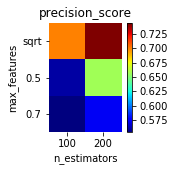

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


In [244]:
best_model, best_score, all_models, all_scores = pf.bestFit(RandomForestClassifier, paramGrid, 
     train_set[features], train_set['ARR_DEL15'], val_set[features], val_set['ARR_DEL15'],
     metric = precision_score, bestScore='max', scoreLabel="precision_score")
print(best_model)

In [245]:
m_best = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
%time m_best.fit(train_set[features], train_set['ARR_DEL15'])

CPU times: user 1min 3s, sys: 13.5 s, total: 1min 16s
Wall time: 27.5 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [248]:
print_score(m_best,train_set[features], train_set['ARR_DEL15'], val_set[features], val_set['ARR_DEL15'] )

[0.00074500786071286101, 0.00067895020251445691]


## Model insights
#### Feature importance

In [254]:
fi = rf_feat_importance(m_best, train_set[features])

In [255]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

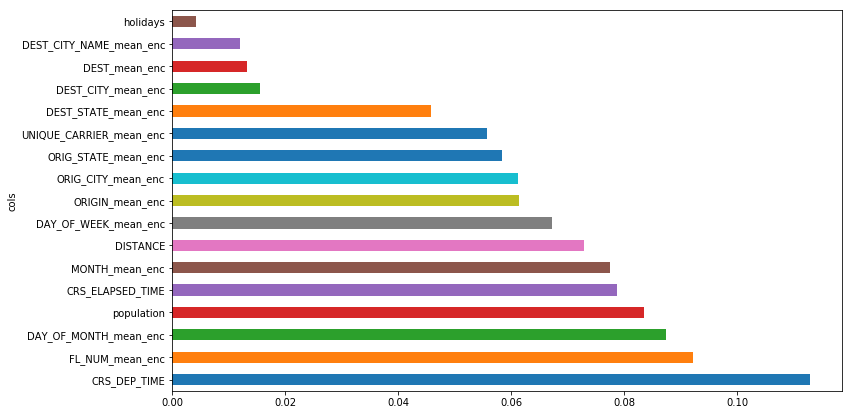

In [256]:
plot_fi(fi);

lessons learnt:
- holiday is not the most important reasons - it didn't add pressure enough to collapse the traffic
- departure time ranks highest - rush hour is an important factor
- flight number also ranks high - which line is an important reasons
- population indicates the popularity of the airport, also an important factor

To sum up, two type of factors matter:
time related: hour of the day
geo related: population and flight line

#### Similar features

In [257]:
from scipy.cluster import hierarchy as hc

In [258]:
corr = np.round(scipy.stats.spearmanr(train_set[features]).correlation, 4)

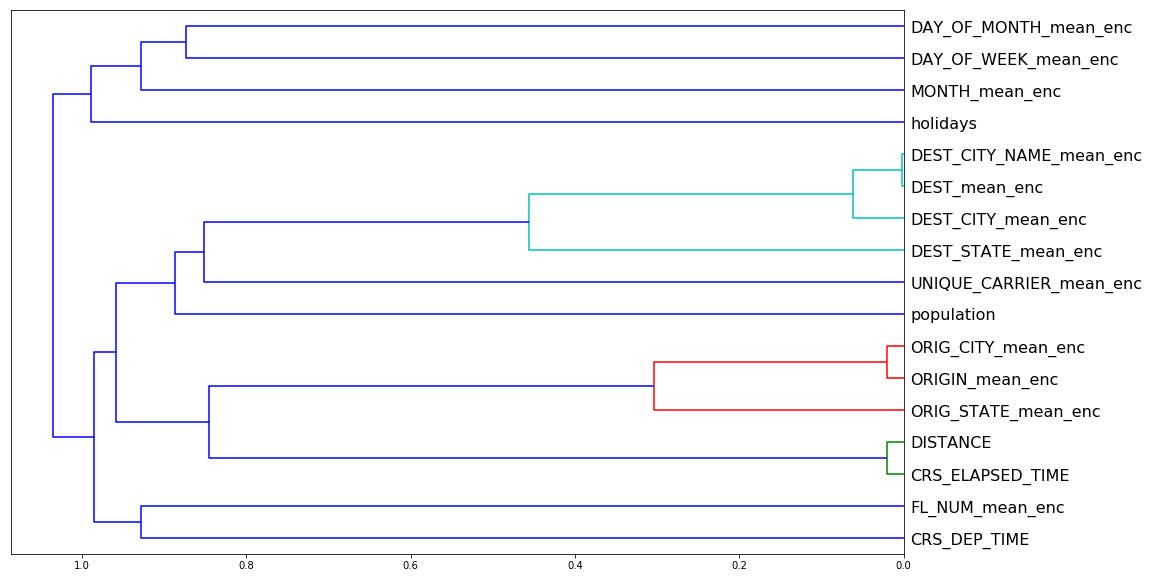

In [260]:
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=features, orientation='left', leaf_font_size=16)
plt.show()

The above graph also shows that important time or geo related features tend to correlate with each other